In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_training.csv')
df_test = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_testing.csv')

In [2]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [3]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train.shape

(597, 200)

In [5]:
# reshape inputs for LSTM [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) # X_train 
print("Training data shape:", x_train.shape)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # X_test 
print("Test data shape:", x_test.shape)

Training data shape: (597, 1, 200)
Test data shape: (198, 1, 200)


## Primer MODELO -- mediante LSTM

In [54]:
## Autoencoder simple 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

PRIMER Modelo LSTM -- utilizando el Keras Tuner

In [13]:
## Aparte del modelo vamos a definir los hiperparametros construyendo el hypermodelo
## Vamos a utilizar o bien una funccion builder o utilizar una subclase HyperModel usando la Keras Tuner 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers
import kerastuner as kt

import numpy as np
import matplotlib.pyplot as plt
def build_model(hp):
    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
    #  for x in range(hp.Int('conv_blocks', 3, 5, default=3)): ## multiples capas de tipo conv blocks
    filters = hp.Int('units', min_value = 16, max_value = 128, step=16)
    L1 = LSTM(filters, activation='relu', return_sequences=True, 
            kernel_regularizer=regularizers.l2(0.00))(inputs)

    filters_2 = int(filters / 4)
    L2 = LSTM(filters_2, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(x_train.shape[1])(L2)
    L4 = LSTM(filters_2, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(filters, activation='relu', return_sequences=True)(L4) 

    output = TimeDistributed(Dense(x_train.shape[2]))(L5)    

    model = Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, 1e-1)),
        loss='mae', 
        metrics=['mae', 'mse', 'mape', 'msle', 'cosine_proximity'])

    model.summary()

    return model 

In [14]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 200)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             13888     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
__________________________________

In [15]:
tuner.search(x_train, epochs = 10, validation_data = x_test, verbose = 1, shuffle=False)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |4                 |?                 
filters_0         |32                |?                 
filters_1         |64                |?                 
filters_2         |32                |?                 
learning_rate     |0.00026934        |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |3                 |?                 
tuner/round       |0                 |?                 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 200)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             13888     
__________________________________________________

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, epochs = 10, validation_data = x_test)

IndexError: list index out of range

In [8]:
# create the autoencoder model
model = autoencoder_model(x_train)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 200)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             29824     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 592       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 32)             4736      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 200)           

In [9]:
# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()

history = model.fit(x_train, x_train, epochs=100, batch_size=32,
                    validation_split=0.1, 
                    verbose= 0).history # we use 10% of the training data for validation 
                                                               
dtrain['A'] = history['loss']
val['B'] = history['val_loss']


In [10]:
x_train.shape

(597, 1, 200)

                A
count  100.000000
mean     0.039939
std      0.131085
min      0.001380
25%      0.001393
50%      0.001403
75%      0.001422
max      0.598979


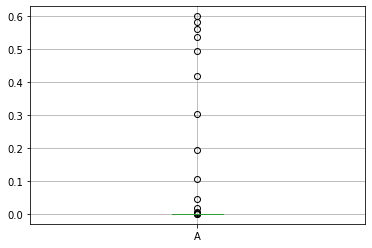

In [11]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [12]:
print("Best MAE on Validation Set =", max(history['val_mae']))

Best MAE on Validation Set = 0.5894515514373779


In [13]:
loss = model.evaluate(x_test, x_test, verbose=0)
print(loss)

[0.0013854558346793056, 0.0013854558346793056, 2.7805438094219426e-06, 0.5372998118400574, 5.106517164676916e-07, 0.9999971389770508]


In [14]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.0013854558346793056
mae 0.0013854558346793056
mse 2.7805438094219426e-06
mape 0.5372998118400574
msle 5.106517164676916e-07
cosine_proximity 0.9999971389770508


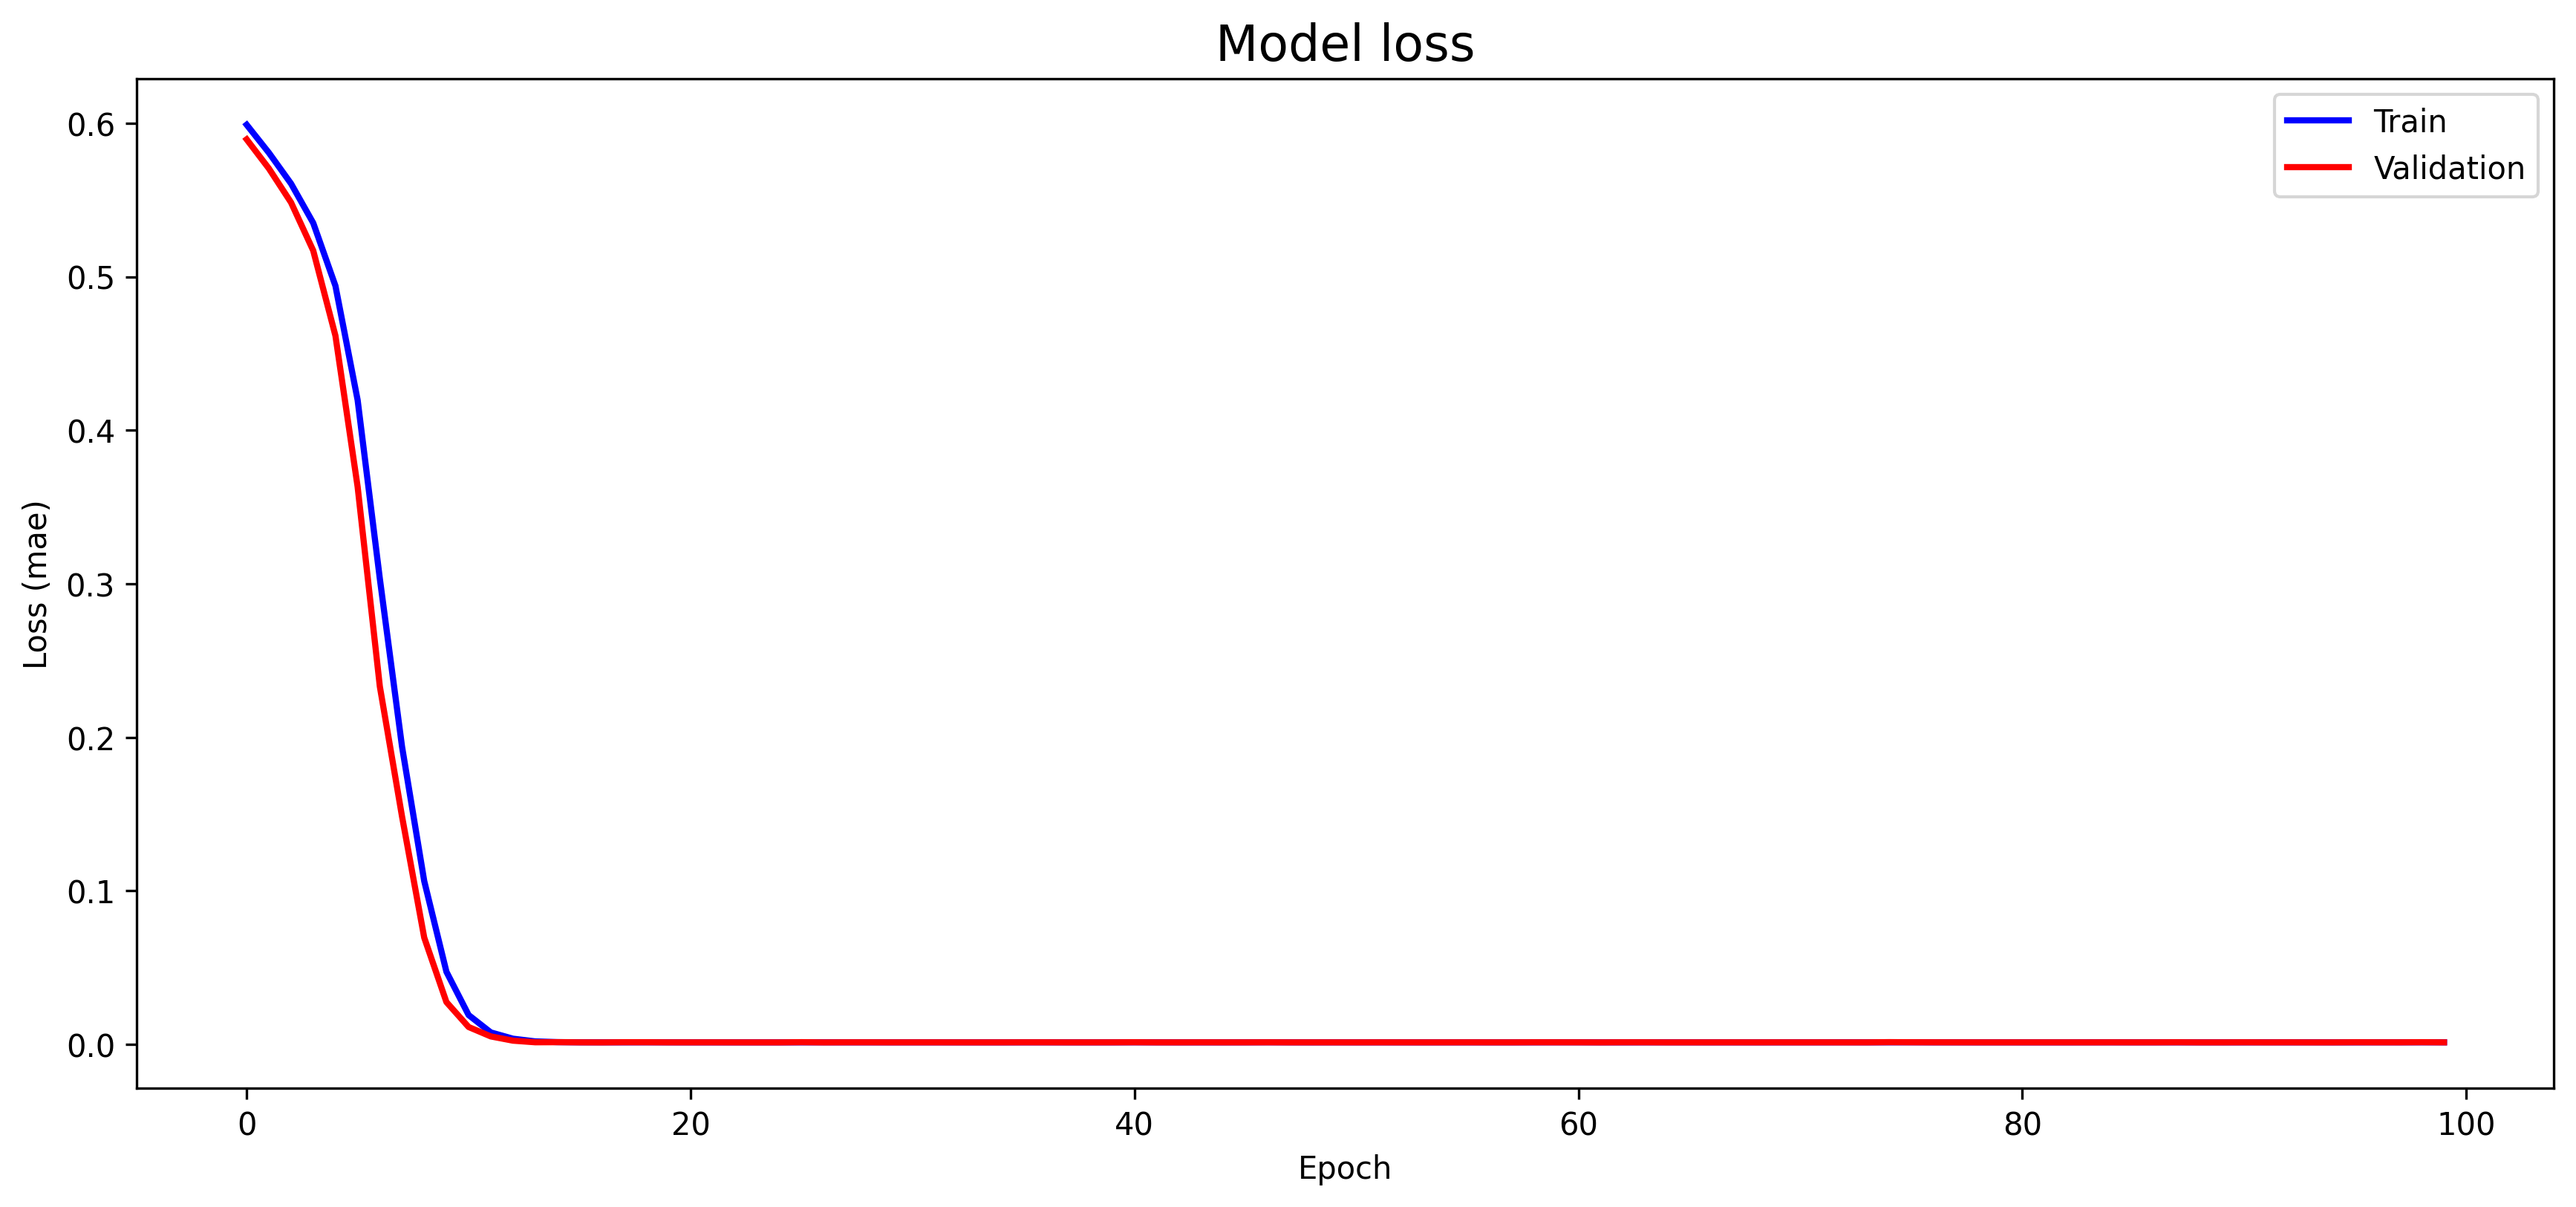

In [15]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

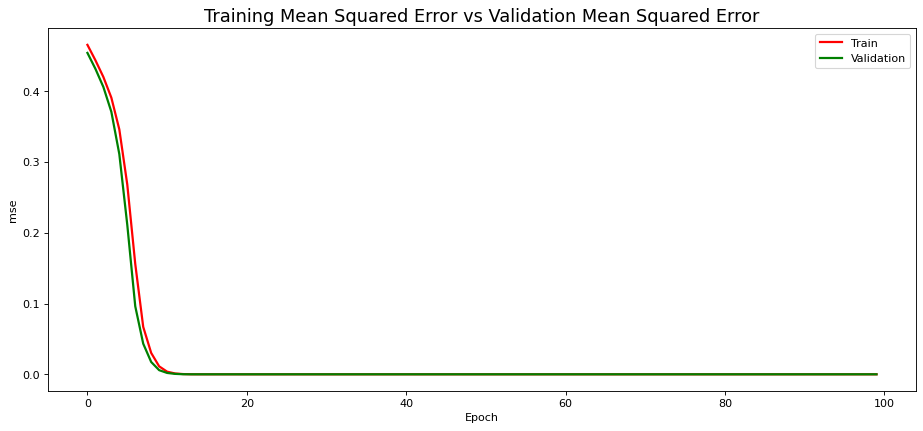

In [16]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

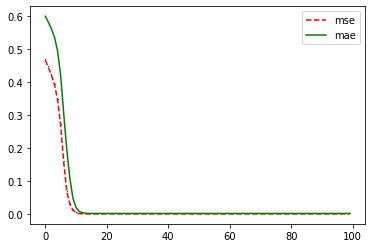

In [17]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
plt.legend(loc='upper right')
plt.show()

"\nXPred = XPred.reshape(XPred.shape[0] * XPred.shape[2], XPred.shape[1])\nXPred = pd.DataFrame(XPred, columns=['text'])\nXPred.index = df_train.index * 200\n\nscored = pd.DataFrame(index=df_train.index)\nXtrain = x_train.reshape(x_train.shape[0] * x_train.shape[2], x_train.shape[1])\nscored['Loss_mae'] = np.mean(np.abs(XPred-Xtrain), axis = 1)\n\n\nplt.figure(figsize=(16,9), dpi= 300)\nplt.title('Loss Distribution', fontsize=16)\nsns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue')\nplt.xlim([0.001,0.004])\n"

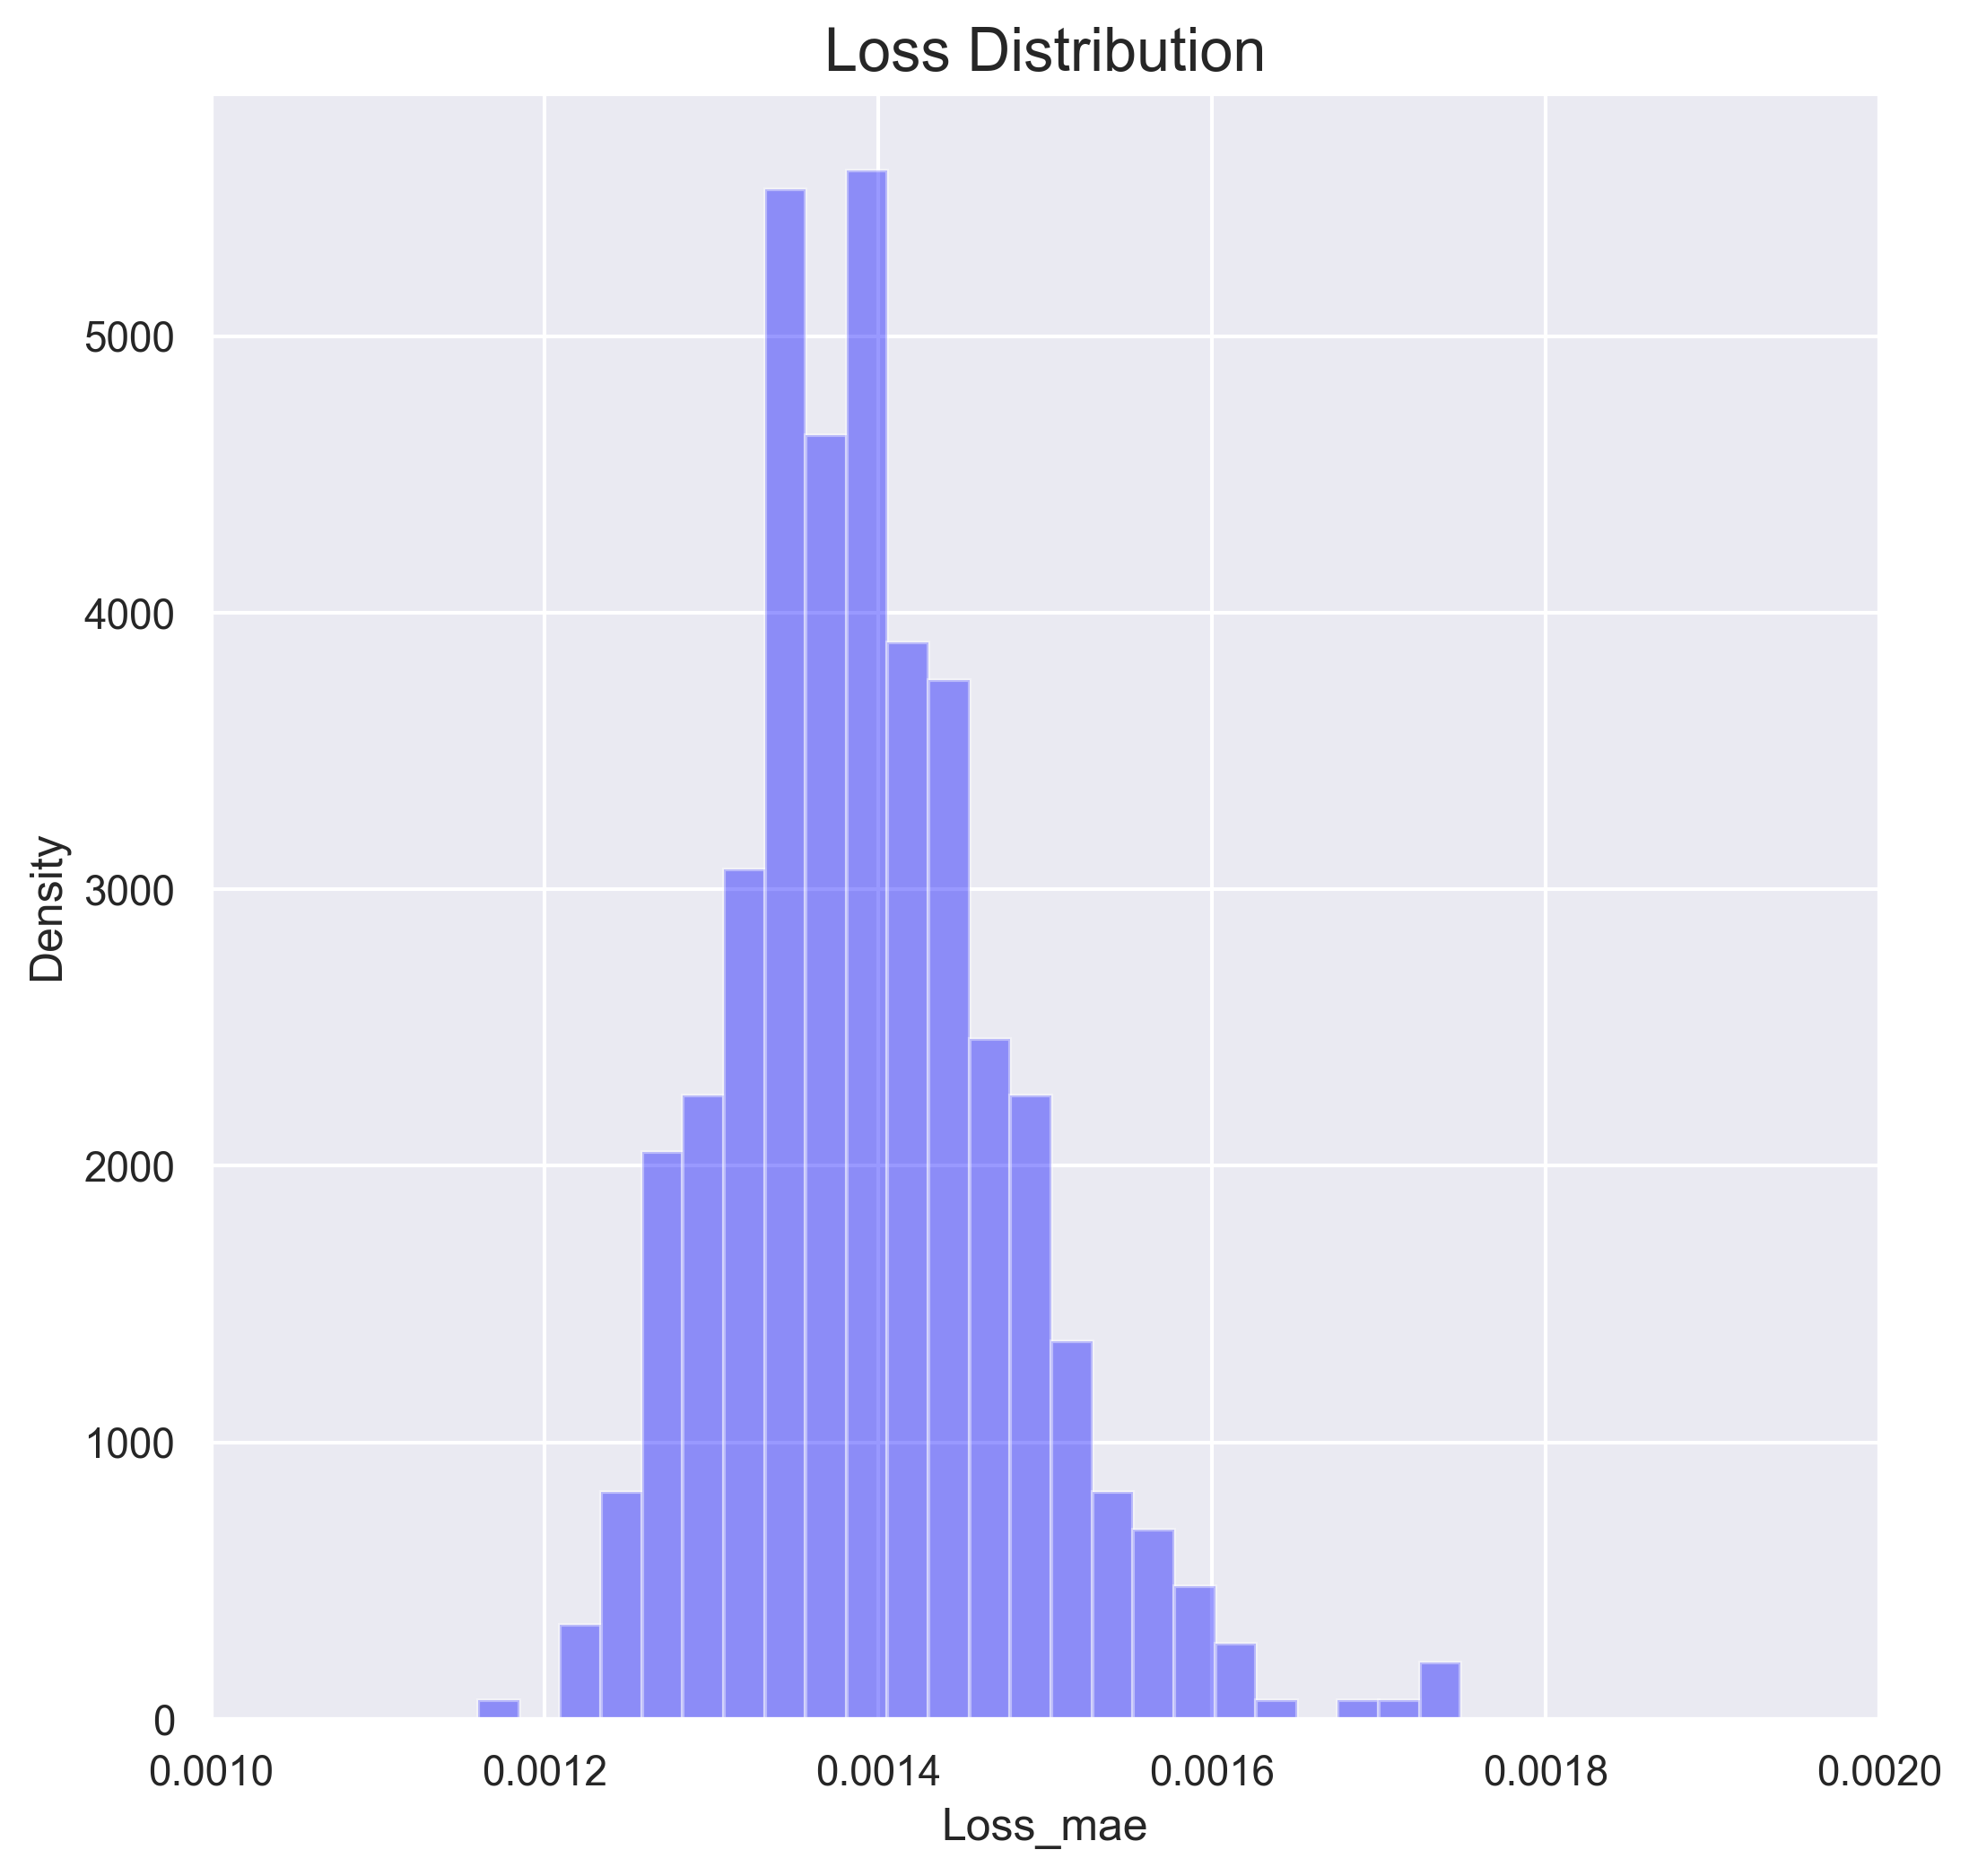

In [18]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
XPred = model.predict(x_train)
XPred = XPred.reshape(XPred.shape[0], XPred.shape[2])

XPred = pd.DataFrame(XPred)

XTrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored = pd.DataFrame(index=XPred.index)
scored['Loss_mae'] = np.mean(np.abs(XPred-XTrain), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], color = 'blue')
plt.xlim([0.001,0.002])
"""
XPred = XPred.reshape(XPred.shape[0] * XPred.shape[2], XPred.shape[1])
XPred = pd.DataFrame(XPred, columns=['text'])
XPred.index = df_train.index * 200

scored = pd.DataFrame(index=df_train.index)
Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[2], x_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(XPred-Xtrain), axis = 1)


plt.figure(figsize=(16,9), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue')
plt.xlim([0.001,0.004])
"""

In [19]:
# calculate the loss on the test set
XPred = model.predict(x_test)
XPred = XPred.reshape(XPred.shape[0], XPred.shape[2])
XPred = pd.DataFrame(XPred)

scored = pd.DataFrame(index=XPred.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(XPred-Xtest), axis = 1)
scored['Threshold'] = 0.0014
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.001293,0.0014,False
1,0.001360,0.0014,False
2,0.001352,0.0014,False
3,0.001319,0.0014,False
4,0.001395,0.0014,False


In [20]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   198 non-null    float32
 1   Threshold  198 non-null    float64
 2   Anomaly    198 non-null    bool   
dtypes: bool(1), float32(1), float64(1)
memory usage: 2.6 KB


In [21]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(100)

,Loss_mae,Threshold,Anomaly
9,0.001450,0.0014,True
11,0.001489,0.0014,True
17,0.001444,0.0014,True
18,0.001460,0.0014,True
22,0.001450,0.0014,True
...,...,...,...
187,0.001543,0.0014,True
188,0.001404,0.0014,True
189,0.001558,0.0014,True
191,0.001507,0.0014,True


<AxesSubplot:>

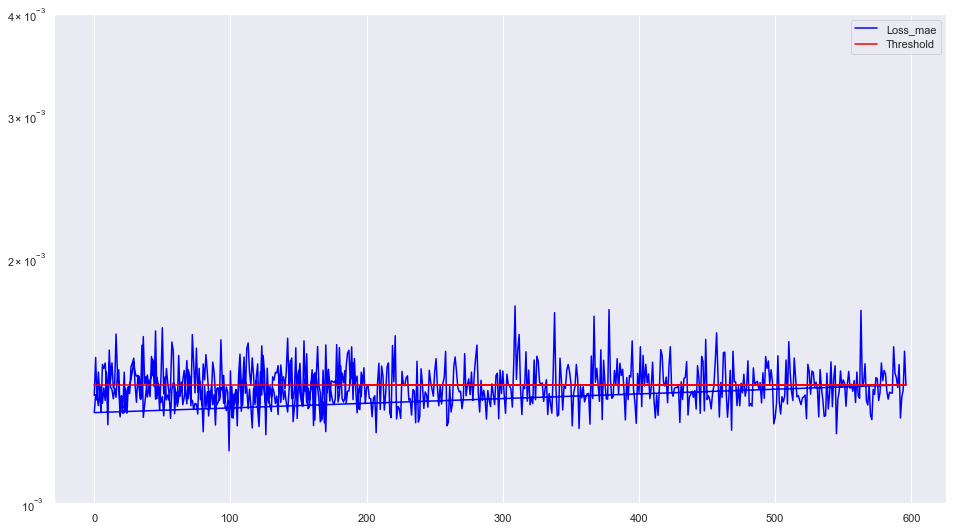

In [22]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(x_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame(index=X_pred_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-XTrain), axis = 1)
scored_train['Threshold'] = 0.0014
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize=(16,9), ylim=[0.001,0.004], color=['blue','red'])

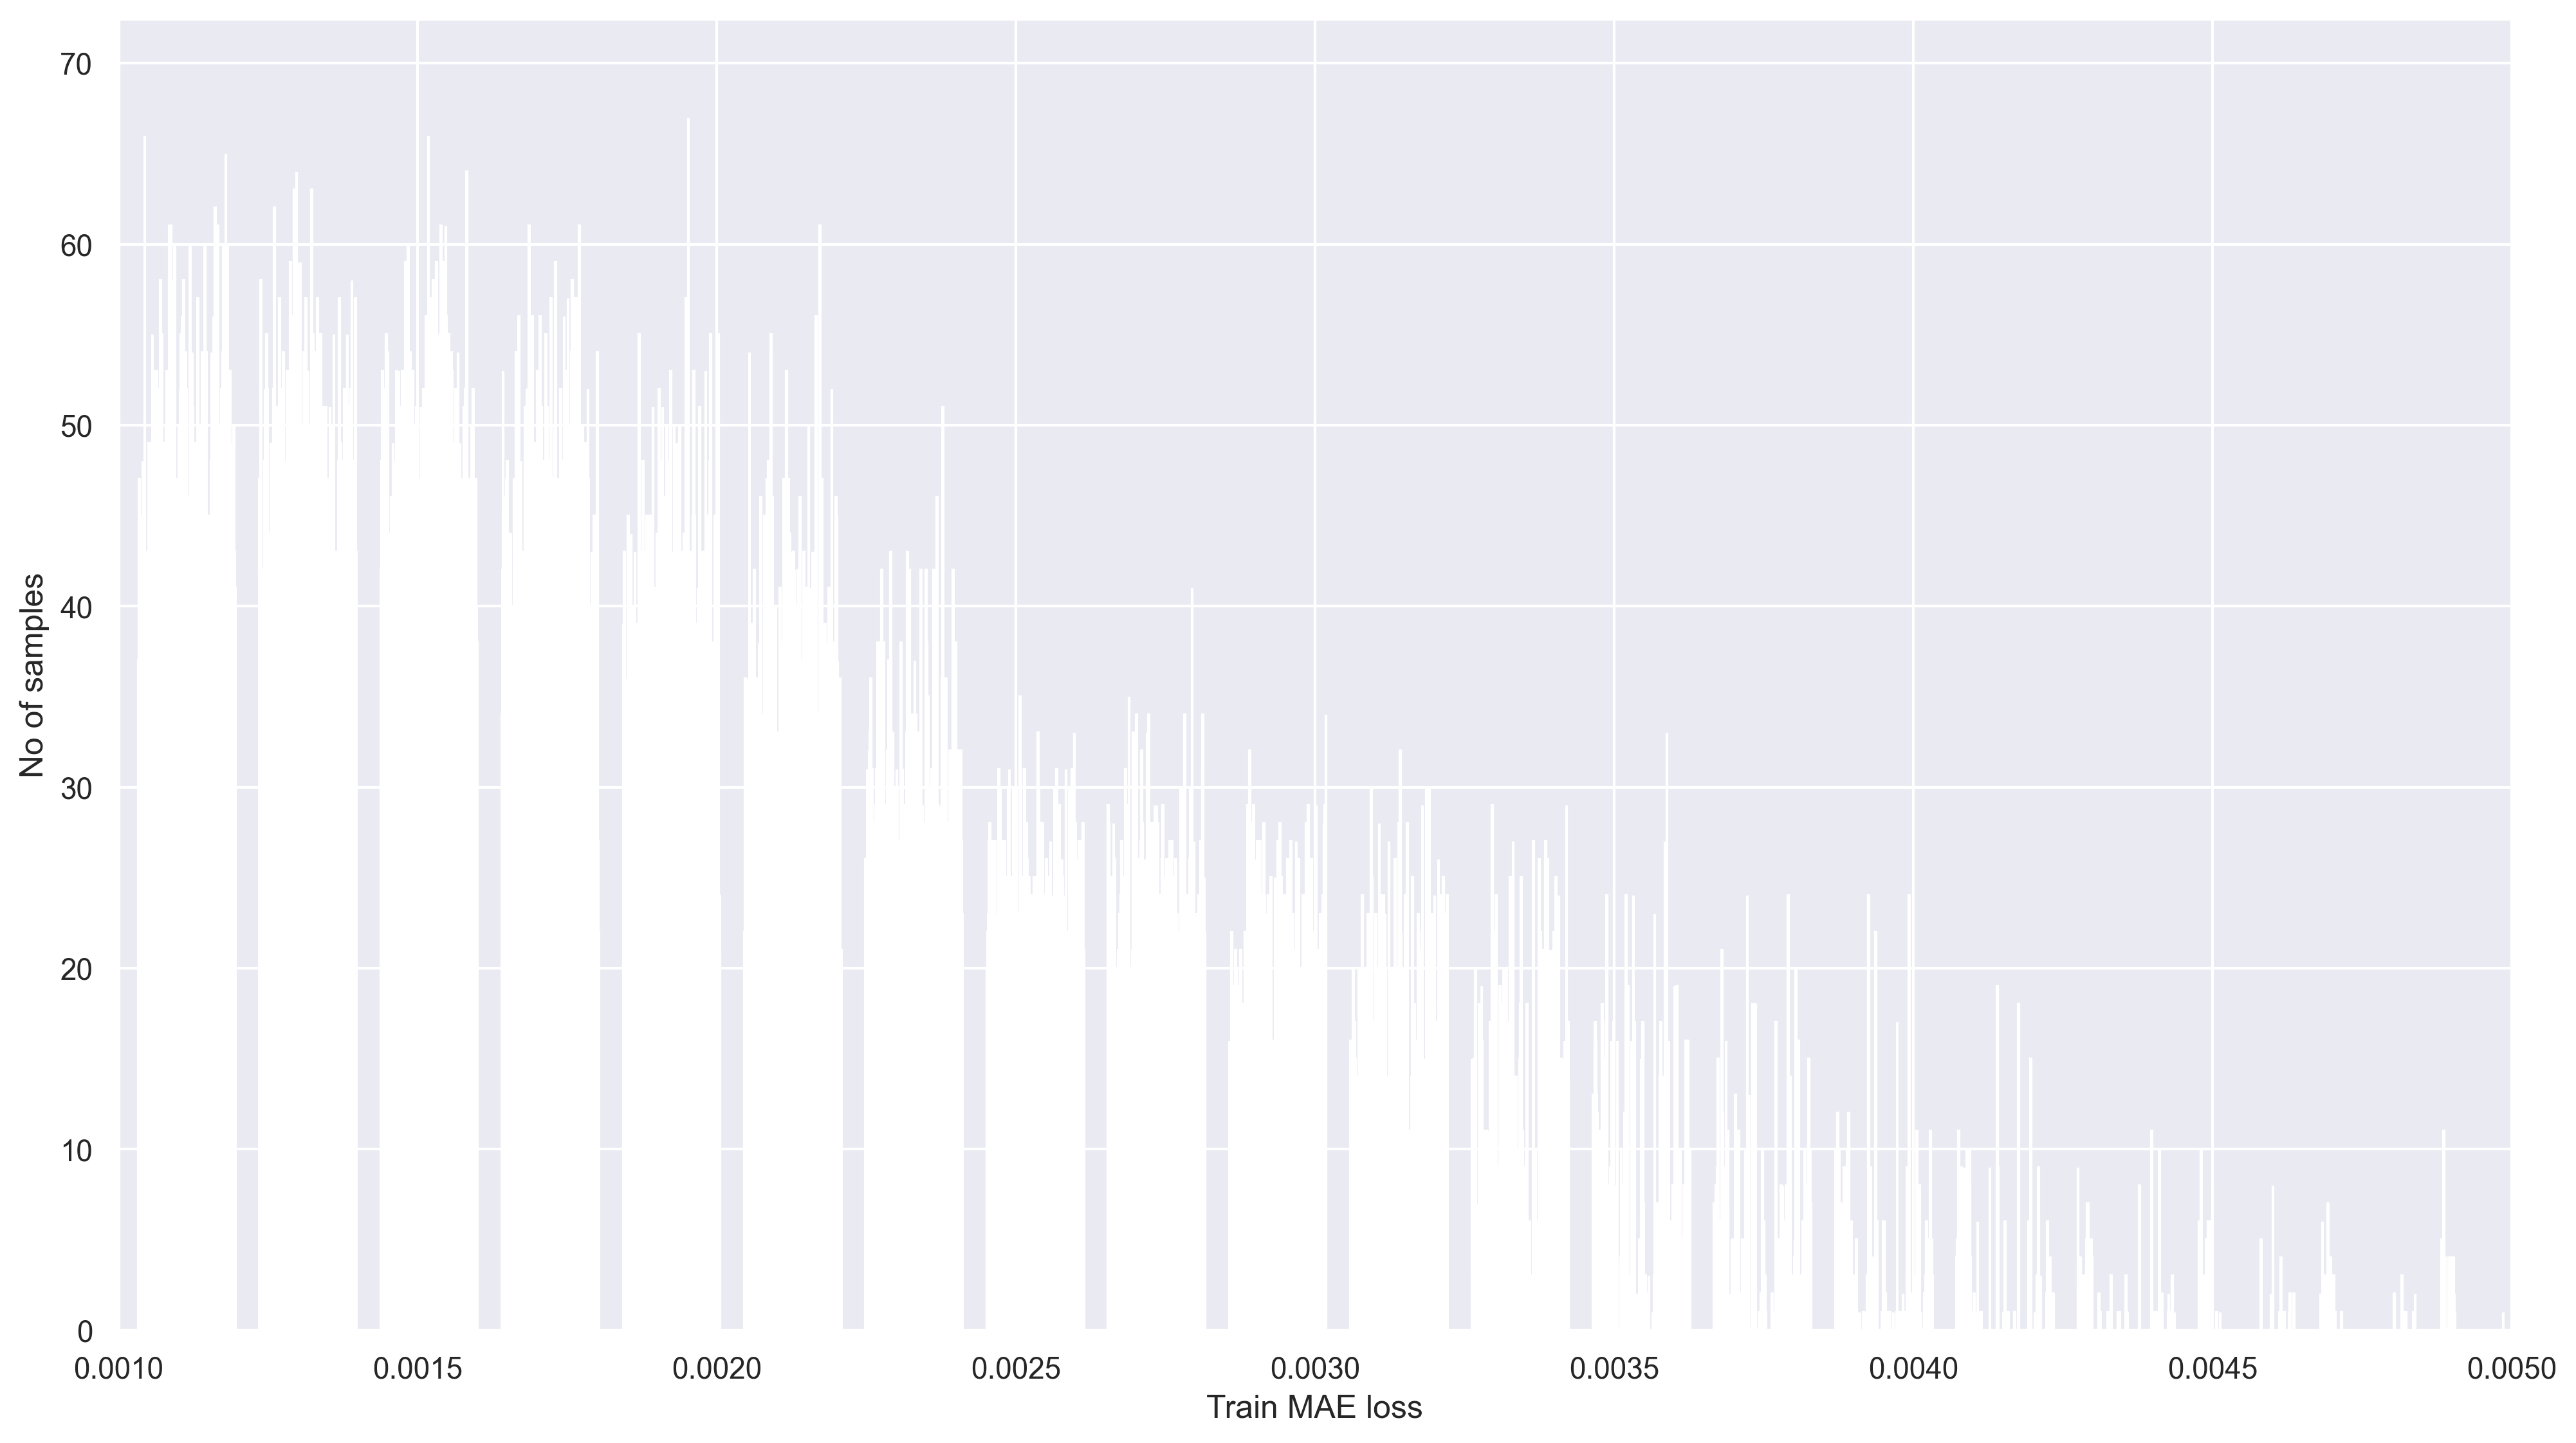

Reconstruction error threshold:  0.008104444


In [23]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
plt.figure(figsize=(16,9), dpi= 300)
plt.hist(train_mae_loss, bins= 40)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.001,0.005])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Segundo modelo -- capas Dense (redes NN)

In [160]:
from keras import models
from keras import layers

model = models.Sequential()
#Capa input
model.add(layers.Input(shape=(x_train.shape[1],x_train.shape[2])))
#Capas ocultas
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
#Capa salida
model.add(layers.Dense(x_train.shape[2], activation = "sigmoid"))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1, 64)             12864     
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 1, 32)             2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1, 64)             2112      
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1, 200)          

In [161]:
model.compile(
 optimizer = "adam",
 loss = "mae",
 metrics = ['mae', 'mse']
)

In [163]:
history = model.fit(
 x_train, x_train,
 epochs= 50,
 batch_size = 32,
 validation_split= 0.1,
)
print("Validation loss:", np.mean(results.history["val_loss"]))

Epoch 1/50
17/17 [==============================] - 0s 4ms/step - loss: 0.3432 - mae: 0.3432 - mse: 0.2586 - val_loss: 0.3477 - val_mae: 0.3477 - val_mse: 0.2588
Epoch 2/50
17/17 [==============================] - 0s 3ms/step - loss: 0.3434 - mae: 0.3434 - mse: 0.2587 - val_loss: 0.3444 - val_mae: 0.3444 - val_mse: 0.2586
Epoch 3/50
17/17 [==============================] - 0s 3ms/step - loss: 0.3430 - mae: 0.3430 - mse: 0.2586 - val_loss: 0.3454 - val_mae: 0.3454 - val_mse: 0.2586
Epoch 4/50
17/17 [==============================] - 0s 3ms/step - loss: 0.3429 - mae: 0.3429 - mse: 0.2586 - val_loss: 0.3451 - val_mae: 0.3451 - val_mse: 0.2586
Epoch 5/50
17/17 [==============================] - 0s 3ms/step - loss: 0.3429 - mae: 0.3429 - mse: 0.2586 - val_loss: 0.3434 - val_mae: 0.3434 - val_mse: 0.2585
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.3429 - mae: 0.3429 - mse: 0.2586 - val_loss: 0.3457 - val_mae: 0.3457 - val_mse: 0.2586
Epoch 7/50
17/17 [==========

               B
count  50.000000
mean    0.341999
std     0.000646
min     0.341074
25%     0.341382
50%     0.341924
75%     0.342574
max     0.343440


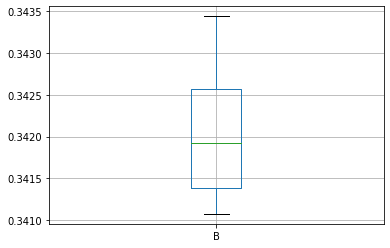

In [167]:
etrain = DataFrame()
etrain['B'] = history.history['loss']
print(etrain.describe())
etrain.boxplot()
plt.show()

In [169]:
print("Best MAE on Validation Set =", max(history.history['val_mae']))

Best MAE on Validation Set = 0.34774214029312134


In [170]:
loss = model.evaluate(x_test, x_test, verbose=0)
print(loss)

[0.3389095067977905, 0.3389095067977905, 0.25836509466171265]


In [171]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.3389095067977905
mae 0.3389095067977905
mse 0.25836509466171265


Tercer modelo -- Variational Autoencoder

In [89]:
## VAE -- utilizando resampling del espacio latente
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input
from keras import backend as BE


original_dim = 200
intermediate_dim = 20
latent_dim = 15 

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [91]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = BE.random_normal(shape=(BE.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + BE.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [92]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [94]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - BE.square(z_mean) - BE.exp(z_log_sigma)
kl_loss = BE.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = BE.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [97]:
history = vae.fit(x_train, x_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_test, x_test))

Epoch 1/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.0374 - val_loss: -1003.2059
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.2063 - val_loss: -1003.1899
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.2899 - val_loss: -1003.2294
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.2867 - val_loss: -1003.4082
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.3859 - val_loss: -1003.3461
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.3194 - val_loss: -1003.0415
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.2278 - val_loss: -1003.2084
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.3300 - val_loss: -1003.1266
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.1444 - val_loss: -1003.3828
Epoch 10/100
19/19 [=================

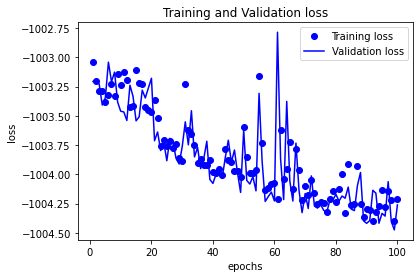

In [103]:
import matplotlib.pyplot as plt


history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
## Creamos el plot para mostrar el loss y val_loss durante los epochs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [87]:
"""
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[0],x_train.shape[1])),
    layers.Conv1D( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1D( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose(1, 7, padding="same"),
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = "mse")
model.summary()
"""

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 299, 32)           44832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 299, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 16)           3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 300, 16)           1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 16)           0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 600, 32)           3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 600, 1)           

In [88]:
history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.1,
    callbacks = [ 
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode="min")
    ]
)

Epoch 1/50


ValueError: in user code:

    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 200]
